In [208]:
# !mkdir data
# !cd data
# !curl -O http://cf.10xgenomics.com/samples/cell-exp/3.0.2/5k_pbmc_v3/5k_pbmc_v3_filtered_feature_bc_matrix.tar.gz
# !tar -xzf 5k_pbmc_v3_filtered_feature_bc_matrix.tar.gz


## Import packages

In [209]:
import numpy as np
import pandas as pd
import scanpy as sc

In [210]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [211]:
results_file = 'pbmc3k.h5ad' 

## Read 10X Data

In [212]:
adata = sc.read_10x_mtx(
    './data/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading


... reading from cache file cache/data-filtered_feature_bc_matrix-matrix.h5ad


In [213]:
adata.var_names_make_unique()

In [214]:
adata

AnnData object with n_obs × n_vars = 5025 × 33538 
    var: 'gene_ids', 'feature_types'

normalizing counts per cell
    finished (0:00:00)


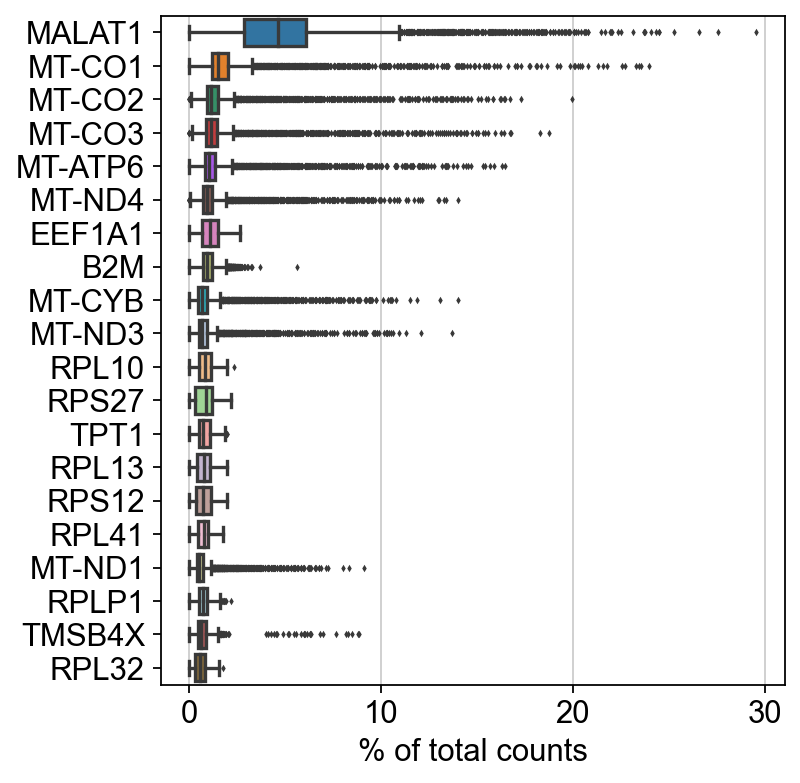

In [215]:
sc.pl.highest_expr_genes(adata, n_top=20, )

## Data Preprocessing

In [216]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 63 cells that have less than 200 genes expressed
filtered out 14747 genes that are detected in less than 3 cells


Calculate percent of mitochondrial; number of genes and number of counts

In [217]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Plot to have a better view:

... storing 'feature_types' as categorical


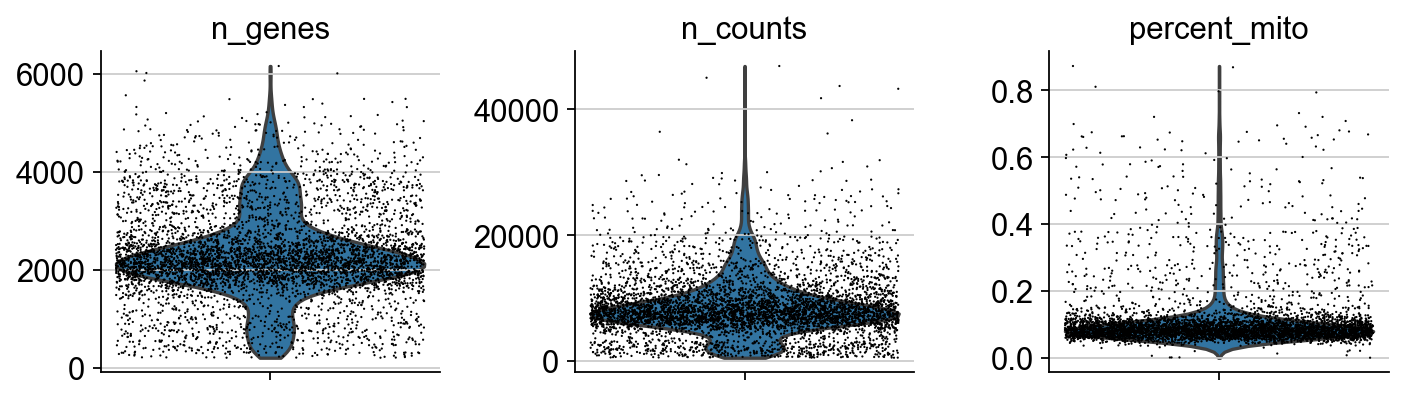

In [218]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

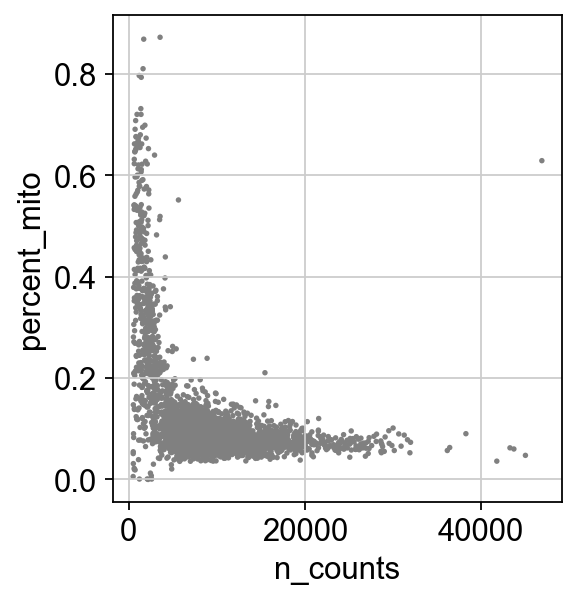

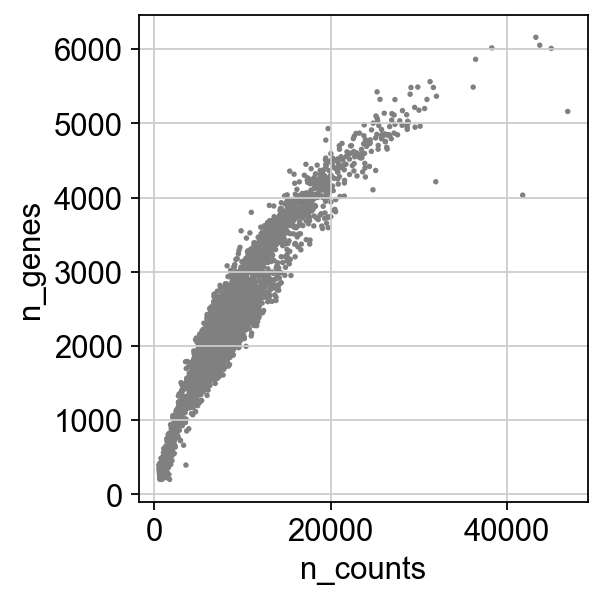

In [219]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [220]:
adata

AnnData object with n_obs × n_vars = 4962 × 18791 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells'

## Data Filtering

In [221]:
adata = adata[adata.obs.n_genes < 5000, :]
adata = adata[adata.obs.percent_mito < 0.25, :]

## Data Normalization

In [222]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:13)


In [223]:
sc.pp.log1p(adata)

/Users/baigal/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Identify highly-variable genes

In [224]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


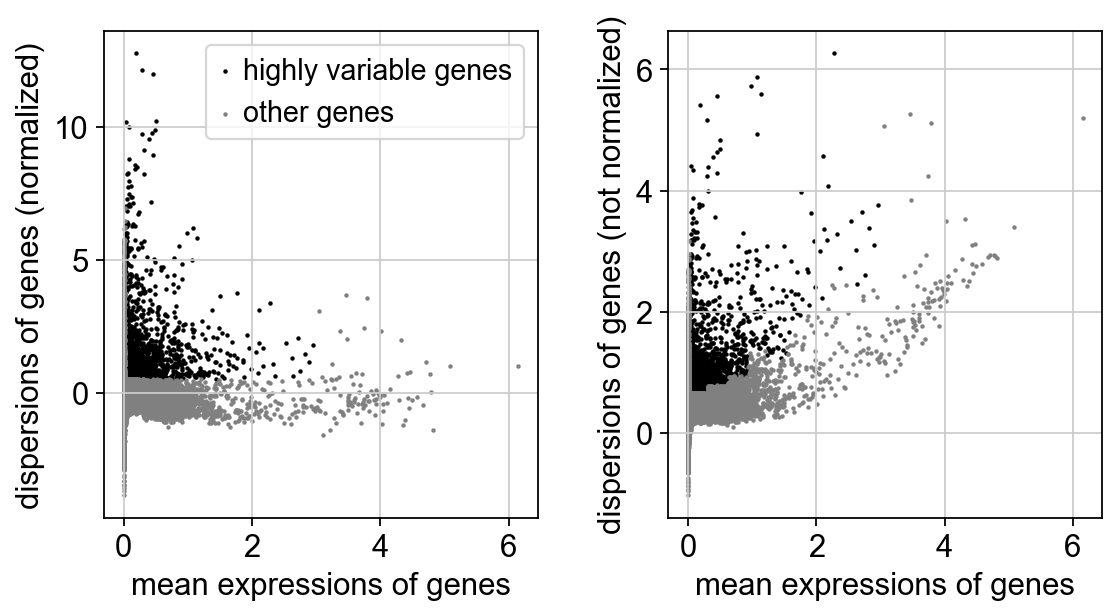

In [225]:
sc.pl.highly_variable_genes(adata)

In [226]:
adata = adata[:, adata.var.highly_variable]

In [247]:
adata

AnnData object with n_obs × n_vars = 4595 × 2278 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Scale the Data

In [227]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


In [228]:
sc.pp.scale(adata, max_value=10)

## Principal Component Analysis

In [229]:
sc.tl.pca(adata, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


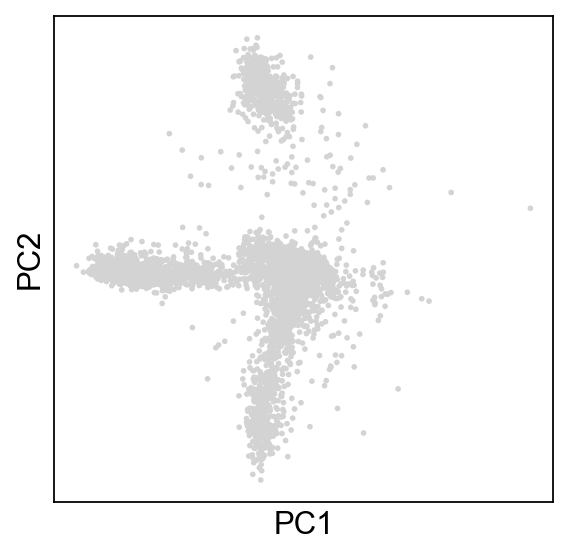

In [248]:
sc.pl.pca(adata)

To determine how many PCs would be appropriate for down stream analysis:

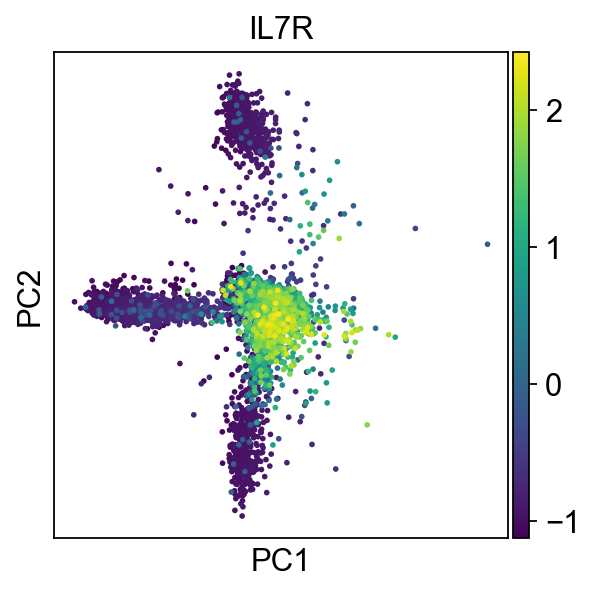

In [249]:
sc.pl.pca(adata, color='IL7R')

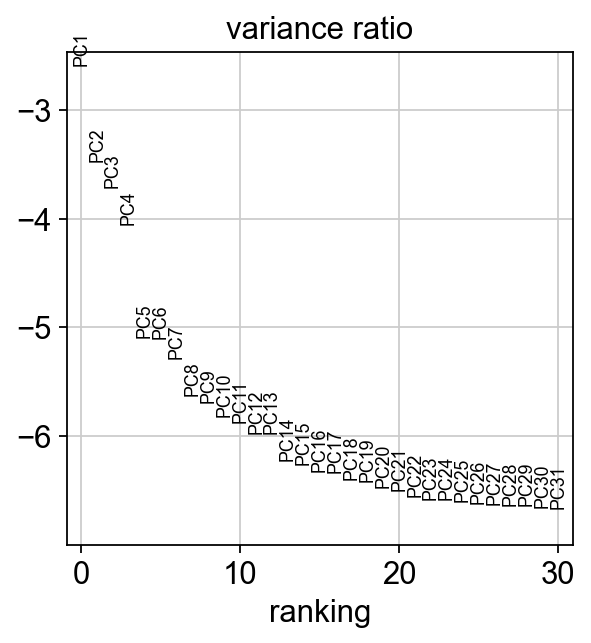

In [231]:
sc.pl.pca_variance_ratio(adata, log=True)

In [232]:
adata.write(results_file)

In [233]:
adata

AnnData object with n_obs × n_vars = 4595 × 2278 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the Neighborhood

In [234]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


## UMAP

In [235]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [236]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


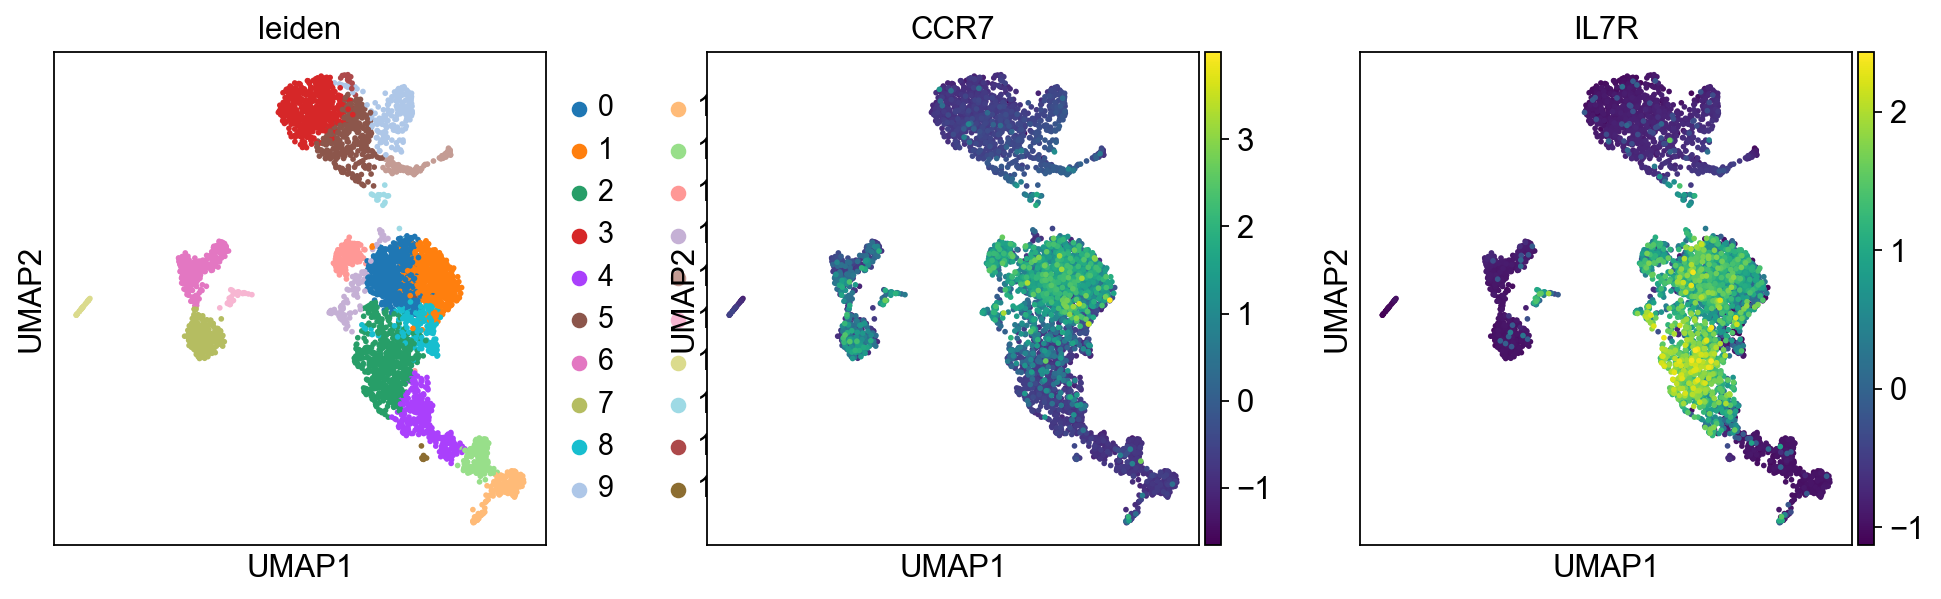

In [237]:
sc.pl.umap(adata, color=['leiden', 'CCR7', 'IL7R'])

## Finding Marker Genes

t-test:

ranking genes


/Users/baigal/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


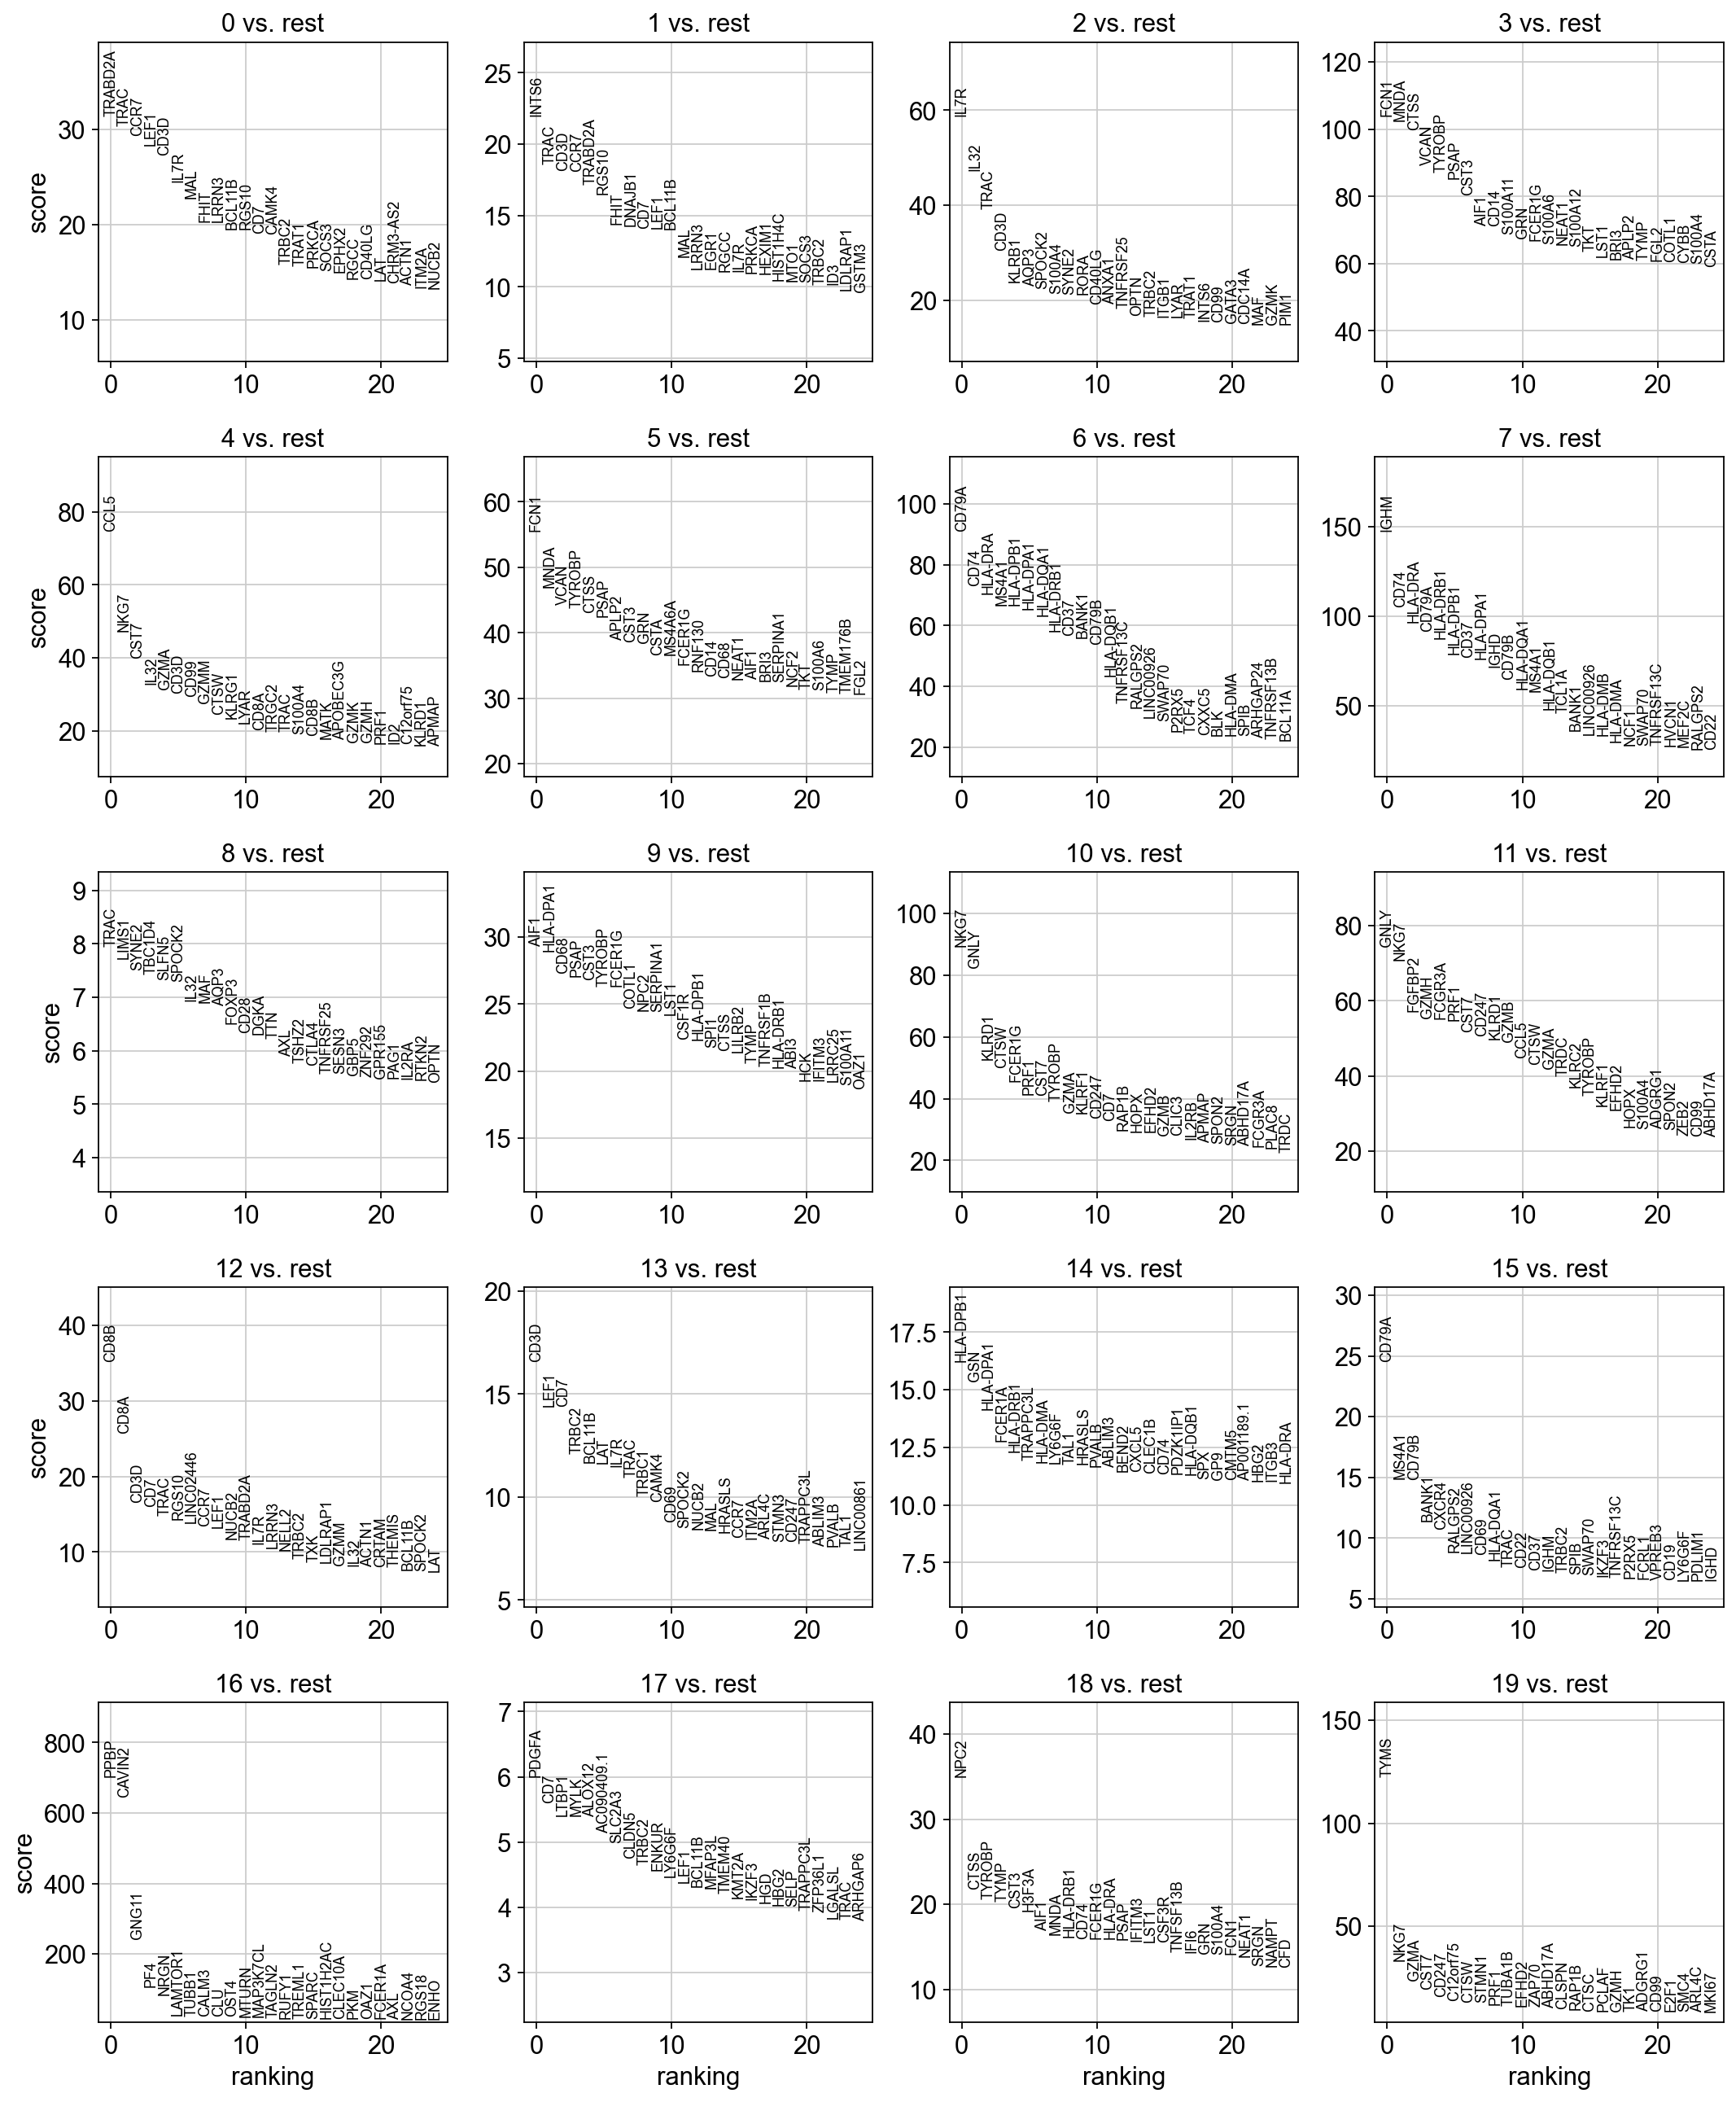

In [238]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [239]:
sc.settings.verbosity = 2

Wilcoxon rank-sum test:

ranking genes


/Users/baigal/miniconda3/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:05)


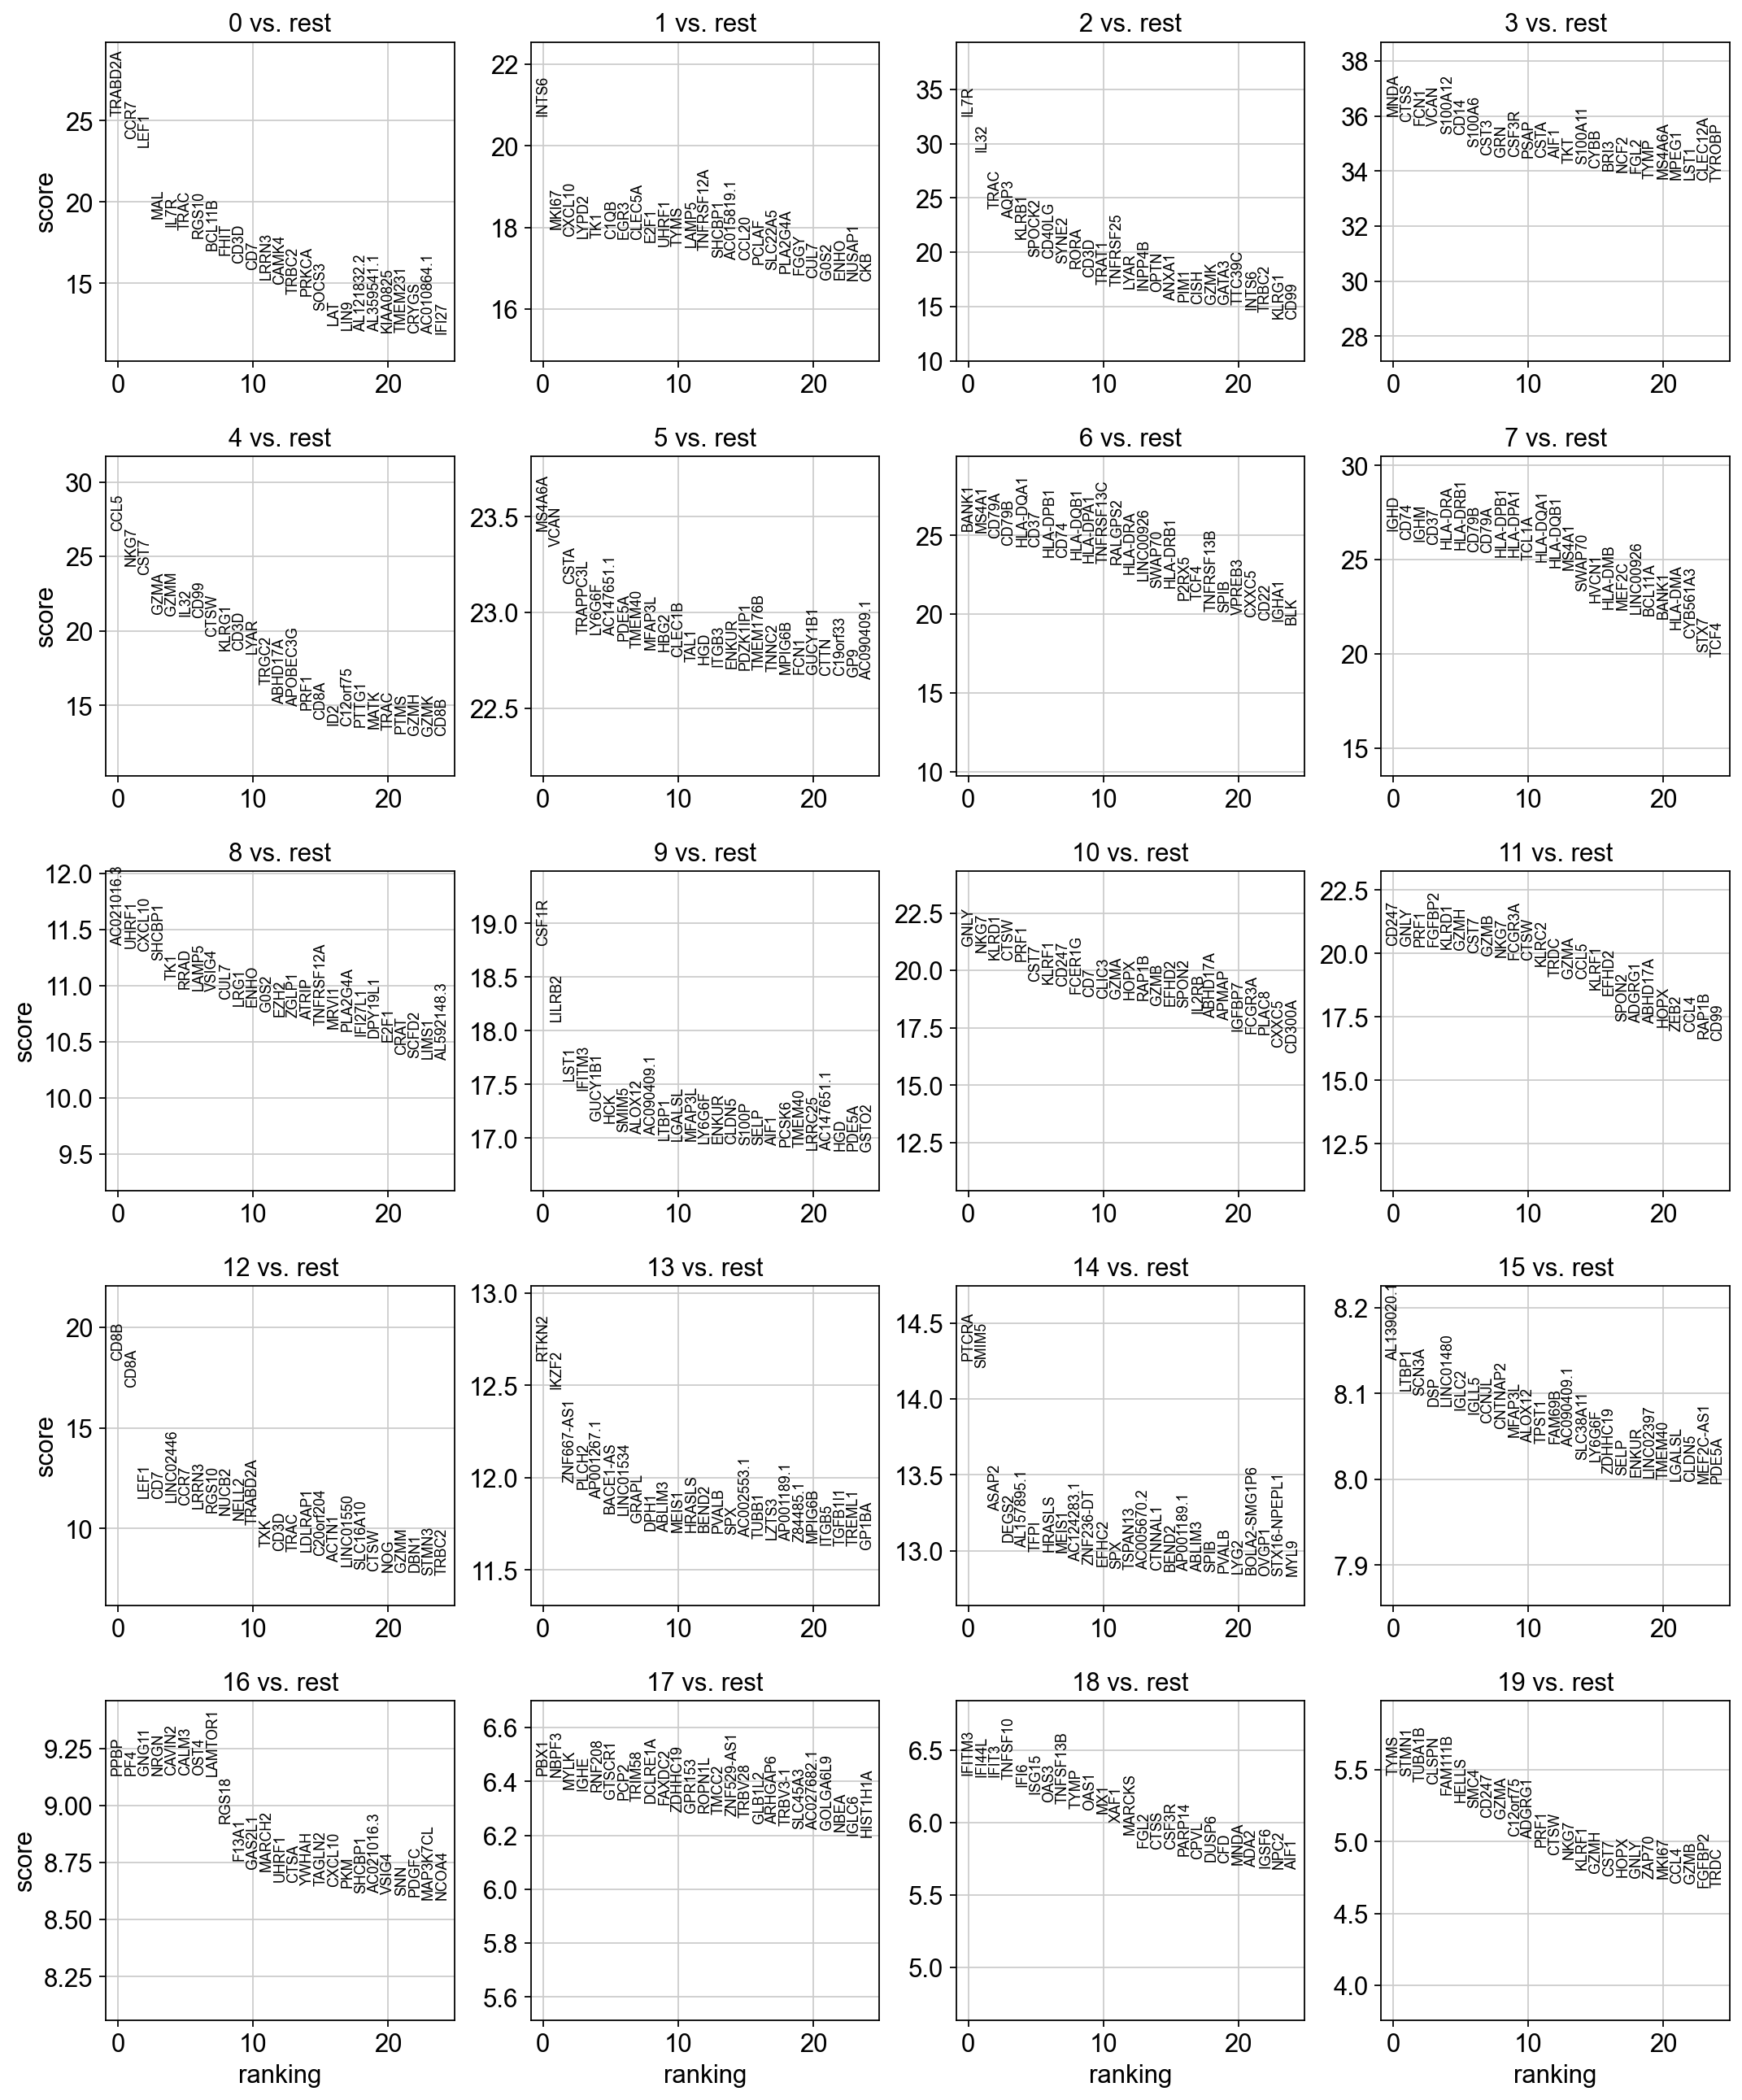

In [240]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [241]:
adata.write(results_file)

Logistic Regression

ranking genes
    finished (0:00:07)


/Users/baigal/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


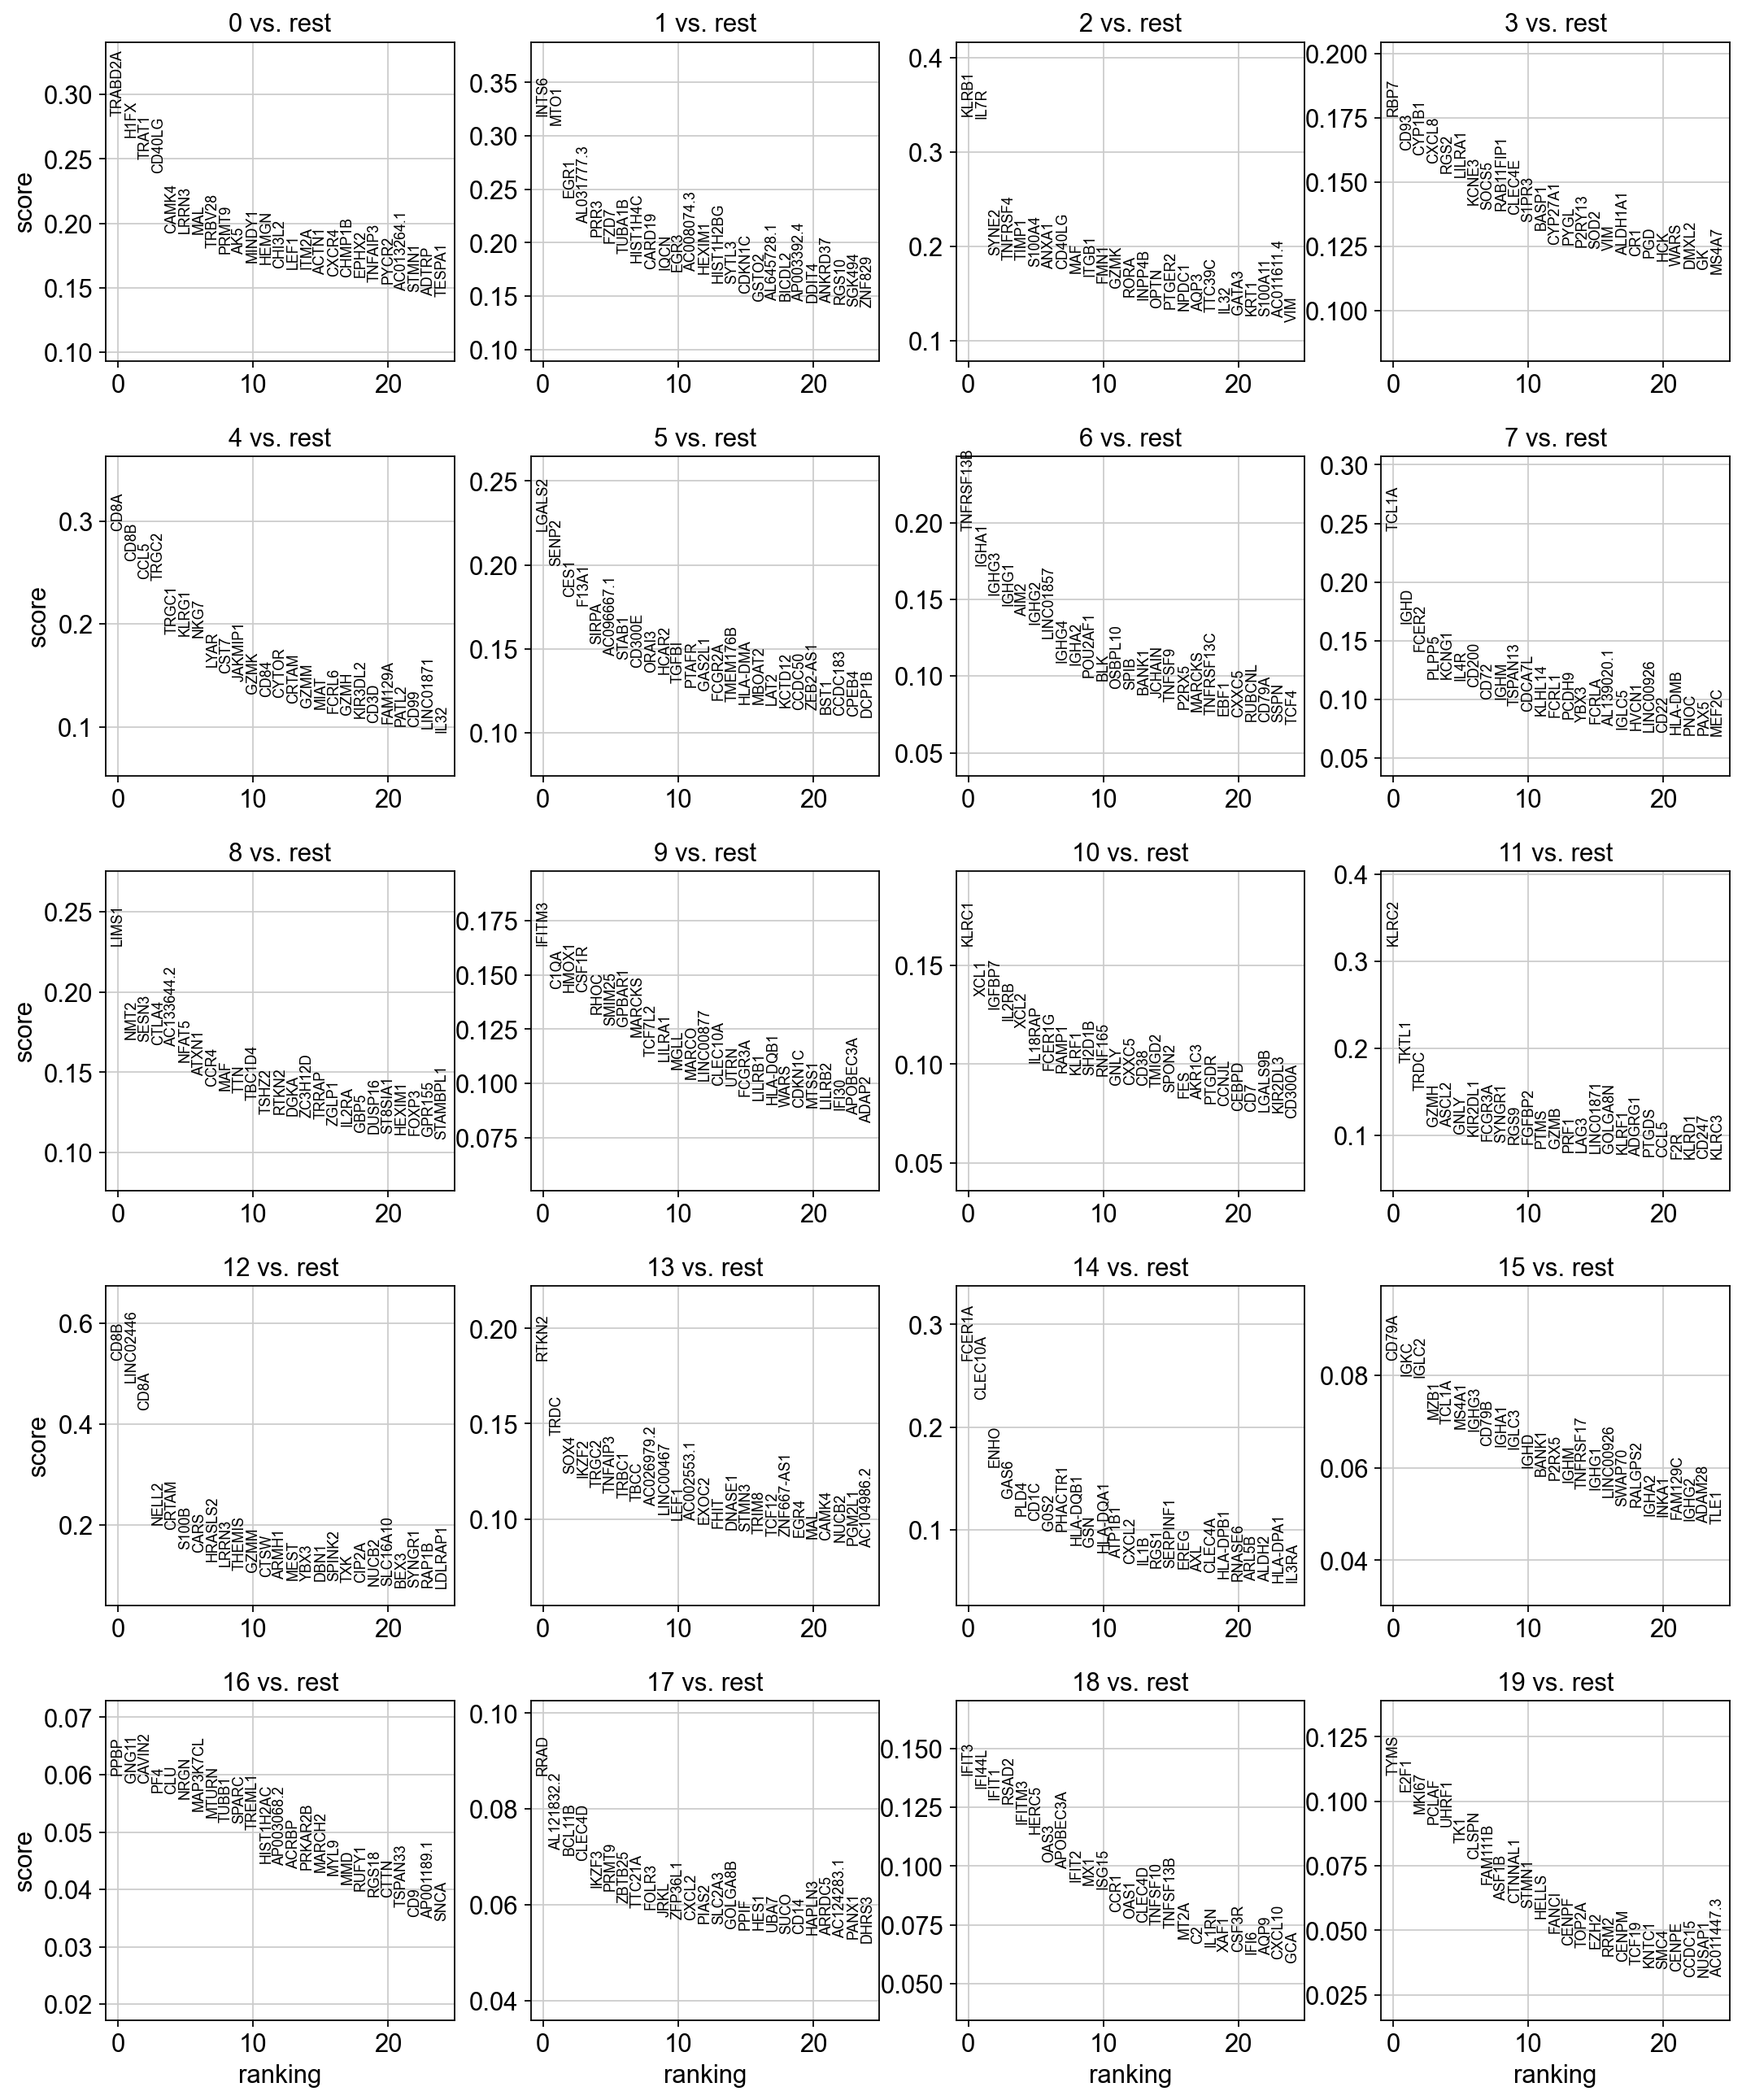

In [242]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [243]:
adata = sc.read(results_file)

In [244]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1      2        3     4         5         6        7  \
0  TRABD2A   INTS6   IL7R     MNDA  CCL5    MS4A6A     BANK1     IGHD   
1     CCR7   MKI67   IL32     CTSS  NKG7      VCAN     MS4A1     CD74   
2     LEF1  CXCL10   TRAC     FCN1  CST7      CSTA     CD79A     IGHM   
3      MAL   LYPD2   AQP3     VCAN  GZMA  TRAPPC3L     CD79B     CD37   
4     IL7R     TK1  KLRB1  S100A12  GZMM    LY6G6F  HLA-DQA1  HLA-DRA   

            8        9     10      11         12          13          14  \
0  AC021016.3    CSF1R   GNLY   CD247       CD8B       RTKN2       PTCRA   
1       UHRF1   LILRB2   NKG7    GNLY       CD8A       IKZF2       SMIM5   
2      CXCL10     LST1  KLRD1    PRF1       LEF1  ZNF667-AS1       ASAP2   
3      SHCBP1   IFITM3   CTSW  FGFBP2        CD7       PLCH2       DEGS2   
4         TK1  GUCY1B1   PRF1   KLRD1  LINC02446  AP001267.1  AL157895.1   

           15      16      17       18       19  
0  AL139020.1    PPBP    PBX1   IFITM3     TYMS  
1       LTBP1     PF4   NBPF3   IFI44L    STMN1  
2       SCN3A   GNG11    MYLK    IFIT3   TUBA1B  
3         DSP    NRGN    IGHE  TNFSF10    CLSPN  
4   LINC01480  CAVIN2  RNF208     IFI6  FAM111B

In [245]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n           1_p    2_n            2_p  \
0  TRABD2A  2.269073e-141   INTS6  1.361320e-95   IL7R  6.475337e-233   
1     CCR7  3.163736e-126   MKI67  3.845632e-72   IL32  8.573137e-189   
2     LEF1  4.364156e-121  CXCL10  7.725898e-71   TRAC  1.115459e-127   
3      MAL   1.018676e-80   LYPD2  1.529517e-70   AQP3  9.086057e-119   
4     IL7R   2.211540e-76     TK1  1.828348e-70  KLRB1  3.991741e-100   

       3_n            3_p   4_n            4_p  ...        15_n          15_p  \
0     MNDA  4.880793e-284  CCL5  9.767965e-158  ...  AL139020.1  3.972651e-16   
1     CTSS  9.572574e-281  NKG7  2.844133e-131  ...       LTBP1  5.311685e-16   
2     FCN1  9.218136e-279  CST7  2.846768e-125  ...       SCN3A  5.569141e-16   
3     VCAN  1.818018e-278  GZMA   1.449280e-99  ...         DSP  6.167520e-16   
4  S100A12  6.678114e-274  GZMM   1.560139e-98  ...   LINC01480  6.174631e-16   

     16_n          16_p    17_n          17_p     18_n          18_p     19_n  \
0    PPBP  6.469113e-20    PBX1  1.311041e-10   IFITM3  2.452783e-10     TYMS   
1     PF4  6.469113e-20   NBPF3  1.387567e-10   IFI44L  2.670153e-10    STMN1   
2   GNG11  6.469113e-20    MYLK  1.838496e-10    IFIT3  2.671896e-10   TUBA1B   
3    NRGN  6.469113e-20    IGHE  1.923643e-10  TNFSF10  3.006362e-10    CLSPN   
4  CAVIN2  6.469113e-20  RNF208  1.968791e-10     IFI6  4.157211e-10  FAM111B   

           19_p  
0  4.550338e-08  
1  4.788937e-08  
2  5.862653e-08  
3  6.479287e-08  
4  9.879907e-08  

[5 rows x 40 columns]

In [246]:
adata = sc.read(results_file)